# Neural Network

## Import and Settings

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV
from joblib import dump, load
import dask.dataframe as dd
import numpy as np

In [3]:
df = dd.read_csv('prepared_ds.csv')

## df_fast initialisieren (size = 0.01)

In [25]:
df_fast = df.sample(frac=0.01, random_state = 2).compute()

In [26]:
df_fast.shape

(75666, 41)

## train, test split

In [27]:
train, test, train_lbl, test_lbl = train_test_split(df_fast[df_fast.columns[1:-1]], df_fast['Label'], test_size=0.2, random_state=1)

In [7]:
continuous_vars = [i for i in train.columns if 'PC-' in i]
category_vars = [i for i in train.columns if i not in continuous_vars]

## Training

In [8]:
clf1 = MLPClassifier(solver='lbfgs', alpha=1e-7, hidden_layer_sizes=(20, 10, 5), random_state=1, max_iter=1000)

In [9]:
clf2 = MLPClassifier(solver='lbfgs', alpha=1e-8, hidden_layer_sizes=(20, 10, 5), random_state=1, max_iter=2000)

Using Grid Search might be better:

In [11]:
clfs = []
for clf_ in [(clf1, 'clf1'), (clf2, 'clf2')]:
    for data in ((continuous_vars, 'con'), (category_vars, 'cat'), (continuous_vars + category_vars, 'all')):
        clf = clf_[0].fit(train[data[0]], train_lbl + f'-{data[1]}')
        clfs.append((clf, clf_[1]))
        print(f'{clf_[1]} - data={data[1]} - accuracy={clf.score(test[data[0]], test_lbl)}')
        for cv in [2, 'prefit']:
            for method in ['sigmoid', 'isotonic']:
              clf_calibrated = CalibratedClassifierCV(clf, cv=cv, method=method, n_jobs=-1)
              clf_calibrated.fit(train[data[0]], train_lbl)
              clfs.append((clf_calibrated, f'{clf_[1]}-{data[1]}-{cv}-{method}'))
              print(f'{clf_[1]} - data={data[1]} - cv={cv:20}, method={method:10s} - accuracy={v}')
    print()

clf1 - data=con - accuracy=0.9950442711774812
clf1 - data=con - cv=                   2, method=sigmoid    - accuracy=0.9945156601030791
clf1 - data=con - cv=                   2, method=isotonic   - accuracy=0.9942513545658782
clf1 - data=con - cv=prefit              , method=sigmoid    - accuracy=0.9949121184088807
clf1 - data=con - cv=prefit              , method=isotonic   - accuracy=0.9949121184088807
clf1 - data=cat - accuracy=0.9017444165455266
clf1 - data=cat - cv=                   2, method=sigmoid    - accuracy=0.9017444165455266
clf1 - data=cat - cv=                   2, method=isotonic   - accuracy=0.9017444165455266
clf1 - data=cat - cv=prefit              , method=sigmoid    - accuracy=0.9017444165455266
clf1 - data=cat - cv=prefit              , method=isotonic   - accuracy=0.9017444165455266
clf1 - data=all - accuracy=0.9970926390907889
clf1 - data=all - cv=                   2, method=sigmoid    - accuracy=0.9966961807849875
clf1 - data=all - cv=                   2, 

clf2 - data=all - accuracy=0.9976873265494912
This Model seems better. However, it produces way worse results concerning the false positive.

In [8]:
parameters = {
    'hidden_layer_sizes': [(20, 10, 5)],
    'max_iter': [1000, 2000],
    'alpha': [1e-3, 1e-4, 1e-5, 1e-7, 1e-8],
    'random_state': [1],
    'activation': ('identity', 'logistic', 'tanh', 'relu'),
    'solver': ('lbfgs', 'sgd', 'adam')
}
mlp = MLPClassifier()
clf = RandomizedSearchCV(mlp, param_distributions=parameters, scoring='accuracy', n_jobs=-1, verbose=4, return_train_score=True)
clf.fit(df_fast[df_fast.columns[1:-1]], df_fast['Label'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=MLPClassifier(), n_jobs=-1,
                   param_distributions={'activation': ('identity', 'logistic',
                                                       'tanh', 'relu'),
                                        'alpha': [0.001, 0.0001, 1e-05, 1e-07,
                                                  1e-08],
                                        'hidden_layer_sizes': [(20, 10, 5)],
                                        'max_iter': [1000, 2000],
                                        'random_state': [1],
                                        'solver': ('lbfgs', 'sgd', 'adam')},
                   return_train_score=True, scoring='accuracy', verbose=4)

In [29]:
print(clf.score(test, test_lbl))

0.9979516320866922


## confusion matrix (fp (wenn 1 (positiv) = DDoS) minimieren)

In [27]:
clf = load('models/neural_network.joblib')

In [33]:
if (clfs == []):
    clf = load('models/neural_network.joblib')
else:
    clf = clfs[-5][0]

In [16]:
confusion_mtx = confusion_matrix(test_lbl, clf.predict(test))

In [17]:
np.round(confusion_mtx/len(test_lbl), 3)

array([[0.827, 0.001],
       [0.001, 0.171]])

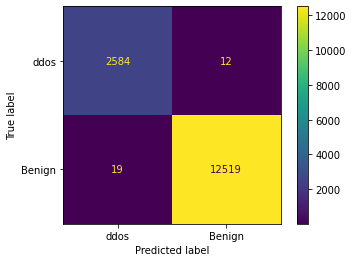

In [18]:
plot_confusion_matrix(clf, test, test_lbl, labels=['ddos', 'Benign'])

In [19]:
# false positive
confusion_mtx[0,1]

19

## Modell speichern

In [15]:
clf.get_params()

{'cv': None,
 'error_score': nan,
 'estimator__activation': 'relu',
 'estimator__alpha': 0.0001,
 'estimator__batch_size': 'auto',
 'estimator__beta_1': 0.9,
 'estimator__beta_2': 0.999,
 'estimator__early_stopping': False,
 'estimator__epsilon': 1e-08,
 'estimator__hidden_layer_sizes': (100,),
 'estimator__learning_rate': 'constant',
 'estimator__learning_rate_init': 0.001,
 'estimator__max_fun': 15000,
 'estimator__max_iter': 200,
 'estimator__momentum': 0.9,
 'estimator__n_iter_no_change': 10,
 'estimator__nesterovs_momentum': True,
 'estimator__power_t': 0.5,
 'estimator__random_state': None,
 'estimator__shuffle': True,
 'estimator__solver': 'adam',
 'estimator__tol': 0.0001,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': False,
 'estimator__warm_start': False,
 'estimator': MLPClassifier(),
 'n_iter': 10,
 'n_jobs': -1,
 'param_distributions': {'hidden_layer_sizes': [(20, 10, 5)],
  'max_iter': [1000, 2000],
  'alpha': [0.001, 0.0001, 1e-05, 1e-07, 1e-08],
  'rand

In [28]:
clf.best_score_

0.9977004204410687

In [20]:
dump(clf, 'models/neural_network_2.joblib')

['models/neural_network_2.joblib']